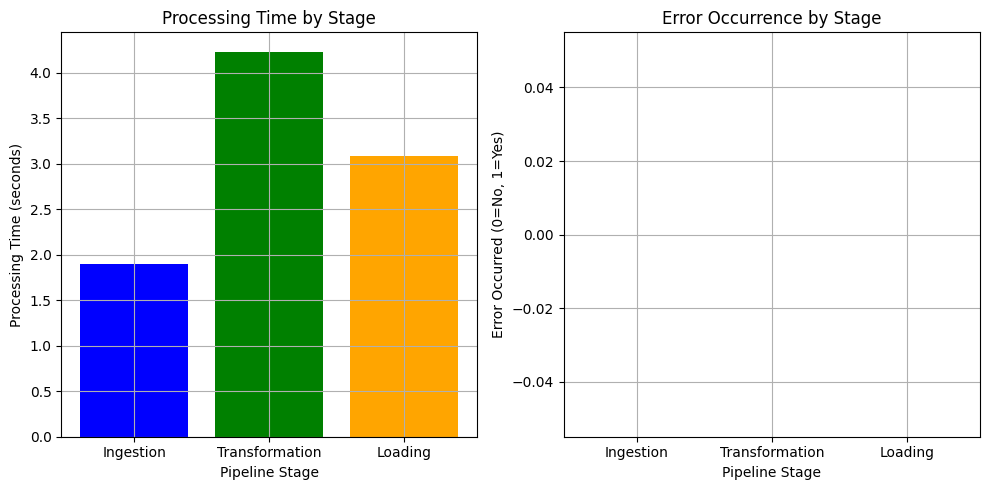

            stage  processing_time  error_occurred
0       Ingestion         1.893871           False
1  Transformation         4.230657           False
2         Loading         3.088351           False


In [ ]:
# import pandas as pd
# import matplotlib.pyplot as plt
# import time
# import random

# # Function to simulate a pipeline stage
# def pipeline_stage(stage_name, min_time, max_time, error_rate):
#     start_time = time.time()
#     time.sleep(random.uniform(min_time, max_time))  # Simulate processing time
#     end_time = time.time()
#     processing_time = end_time - start_time
#     error_occurred = random.random() < error_rate  # Simulate error occurrence
#     return {'stage': stage_name, 'processing_time': processing_time, 'error_occurred': error_occurred}

# # Simulate data pipeline 
# stages = [
#     {'name': 'Ingestion', 'min_time': 1, 'max_time': 2, 'error_rate': 0.1},
#     {'name': 'Transformation', 'min_time': 3, 'max_time': 5, 'error_rate': 0.05},
#     {'name': 'Loading', 'min_time': 2, 'max_time': 4, 'error_rate': 0.02}
# ]

# # Collect metrics
# metrics = []
# for stage in stages:
#     result = pipeline_stage(stage['name'], stage['min_time'], stage['max_time'], stage['error_rate'])
#     metrics.append(result)

# # Convert metrics to DataFrame
# df_metrics = pd.DataFrame(metrics)

# # Visualize metrics
# plt.figure(figsize=(10, 5))

# # Plot processing time
# plt.subplot(1, 2, 1)
# plt.bar(df_metrics['stage'], df_metrics['processing_time'], color=['blue', 'green', 'orange'])
# plt.title('Processing Time by Stage')
# plt.xlabel('Pipeline Stage')
# plt.ylabel('Processing Time (seconds)')
# plt.grid(True)

# # Plot error occurrences
# plt.subplot(1, 2, 2)
# plt.bar(df_metrics['stage'], df_metrics['error_occurred'].astype(int), color=['red', 'yellow', 'purple'])
# plt.title('Error Occurrence by Stage')
# plt.xlabel('Pipeline Stage')
# plt.ylabel('Error Occurred (0=No, 1=Yes)')
# plt.grid(True)

# # Display the plots
# plt.tight_layout()
# plt.show()

# # Display metrics DataFrame
# print(df_metrics)


In [ ]:
import matplotlib.pyplot as plt
import pandas as pd

# Sample data
data = {
    'stage': ['Ingestion', 'Transformation', 'Loading'],
    'processing_time': [120, 300, 180]  # in seconds
}
df = pd.DataFrame(data)

# Plotting the data
plt.figure(figsize=(10, 5))
plt.bar(df['stage'], df['processing_time'], color=['blue', 'green', 'orange'])
plt.title('Data Pipeline Performance')
plt.xlabel('Pipeline Stage')
plt.ylabel('Processing Time (seconds)')
plt.ylim(0, 350)
plt.grid(True)

# Display the plot
plt.show()

# v1

In [ ]:
import pandas as pd


# Load data
def load_data(file_path):
    df = pd.read_csv(file_path)
    return df


# Example usage
file_path = "data/sample_data.csv"
df = load_data(file_path)
print(df.head())

In [ ]:
import great_expectations as ge


def validate_data(df):
    # Convert Pandas DataFrame to Great Expectations DataFrame
    ge_df = ge.from_pandas(df)

    # Define expectations
    ge_df.expect_column_to_exist("column1")
    ge_df.expect_column_values_to_not_be_null("column1")
    ge_df.expect_column_values_to_be_in_set("column2", ["value1", "value2"])

    # Validate data
    results = ge_df.validate()
    return results


# Example usage
results = validate_data(df)
print(results)


In [ ]:
def transform_data(df):
    # Example transformation: Add a new column
    df["new_column"] = df["column1"] * 2
    return df


# Example usage
df_transformed = transform_data(df)
print(df_transformed.head())

In [ ]:
from kedro.pipeline import Pipeline, node


def create_pipeline():
    return Pipeline(
        [
            node(load_data, "params:file_path", "df"),
            node(validate_data, "df", "validation_results"),
            node(transform_data, "df", "df_transformed"),
        ]
    )


# Example usage
pipeline = create_pipeline()

In [ ]:
from airflow import DAG
from airflow.operators.python_operator import PythonOperator
from datetime import datetime

default_args = {
    'owner': 'airflow',
    'start_date': datetime(2023, 1, 1),
    'retries': 1
}

dag = DAG('data_pipeline', default_args=default_args, schedule_interval='@daily')

def load_and_validate_data():
    df = load_data(file_path)
    results = validate_data(df)
    if not results['success']:
        raise ValueError("Data validation failed")
    return df

def transform_and_save_data(df):
    df_transformed = transform_data(df)
    df_transformed.to_csv('data/transformed_data.csv', index=False)

load_validate_task = PythonOperator(
    task_id='load_and_validate_data',
    python_callable=load_and_validate_data,
    dag=dag
)

transform_save_task = PythonOperator(
    task_id='transform_and_save_data',
    python_callable=transform_and_save_data,
    provide_context=True,
    dag=dag
)

load_validate_task >> transform_save_task

# v2

In [8]:
import pandas as pd
import numpy as np

def generate_sample_data(num_rows):
    np.random.seed(0)  # For reproducibility
    data = {
        'column1': np.random.randint(1, 100, num_rows),
        'column2': np.random.choice(['value1', 'value2'], num_rows)
    }
    df = pd.DataFrame(data)
    return df

# Example usage
num_rows = 100
sample_data = generate_sample_data(num_rows)
print(sample_data.head())

   column1 column2
0       45  value2
1       48  value1
2       65  value2
3       68  value2
4       68  value1


In [13]:
import pandas as pd
import matplotlib.pyplot as plt
import great_expectations as ge
from kedro.pipeline import Pipeline, node
from kedro.runner import SequentialRunner 
from kedro.io import DataCatalog, MemoryDataset
import time
import random

# Sample data generator
def generate_sample_data(num_rows):
    np.random.seed(0)  # For reproducibility
    data = {
        'column1': np.random.randint(1, 100, num_rows),
        'column2': np.random.choice(['value1', 'value2'], num_rows)
    }
    df = pd.DataFrame(data)
    return df

# Load data
def load_data():
    df = generate_sample_data(100)
    return df

# Validate data with Great Expectations
def validate_data(df):
    context = ge.get_context()
    ge_df = context.data_sources.add_pandas(df)
    # ge_df = ge.dataset.PandasDataset(df)
    ge_df.expect_column_to_exist('column1')
    ge_df.expect_column_values_to_not_be_null('column1')
    ge_df.expect_column_values_to_be_in_set('column2', ['value1', 'value2'])
    results = ge_df.model_validate()
    if not results['success']: 
        raise ValueError("Data validation failed") 
    return df

# Transform data
def transform_data(df):
    df['new_column'] = df['column1'] * 2
    return df

# Create Kedro pipeline
def create_pipeline():
    return Pipeline(
        [
            node(load_data, None, 'raw_data'),
            node(validate_data, 'raw_data', 'validated_data'),
            node(transform_data, 'validated_data', 'df_transformed')
        ]
    )

# Example usage of Kedro pipeline
pipeline = create_pipeline()
data_catalog = DataCatalog({ 
    "raw_data": MemoryDataset(), 
    "validated_data": MemoryDataset(), 
    "df_transformed": MemoryDataset()
})

# Run the Kedro pipeline
runner = SequentialRunner()
pipeline_output = runner.run(pipeline, catalog=data_catalog)
df_transformed = pipeline_output['df_transformed']

print(df_transformed.head())

[01/16/25 01:15:12] INFO     Using synchronous mode for loading and saving data. Use the    ]8;id=580231;file://c:\Users\arthu\AppData\Local\Programs\Python\Python39\lib\site-packages\kedro\runner\sequential_runner.py\sequential_runner.py]8;;\:]8;id=452958;file://c:\Users\arthu\AppData\Local\Programs\Python\Python39\lib\site-packages\kedro\runner\sequential_runner.py#68\68]8;;\
                             --async flag for potential performance gains.                                         
                             https://docs.kedro.org/en/stable/nodes_and_pipelines/run_a_pip                        
                             eline.html#load-and-save-asynchronously                                               

                    INFO     Running node: load_data(None) -> [raw_data]                                ]8;id=520198;file://c:\Users\arthu\AppData\Local\Programs\Python\Python39\lib\site-packages\kedro\pipeline\node.py\node.py]8;;\:]8;id=731559;file://c:\Users\arthu\AppData\Local\Programs\Python\Python39\lib\site-packages\kedro\pipeline\node.py#367\367]8;;\

                    INFO     Saving data to raw_data (MemoryDataset)...                         ]8;id=216930;file://c:\Users\arthu\AppData\Local\Programs\Python\Python39\lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=201042;file://c:\Users\arthu\AppData\Local\Programs\Python\Python39\lib\site-packages\kedro\io\data_catalog.py#431\431]8;;\

                    INFO     Completed 1 out of 3 tasks                                     ]8;id=699745;file://c:\Users\arthu\AppData\Local\Programs\Python\Python39\lib\site-packages\kedro\runner\sequential_runner.py\sequential_runner.py]8;;\:]8;id=633773;file://c:\Users\arthu\AppData\Local\Programs\Python\Python39\lib\site-packages\kedro\runner\sequential_runner.py#93\93]8;;\

                    INFO     Loading data from raw_data (MemoryDataset)...                      ]8;id=910877;file://c:\Users\arthu\AppData\Local\Programs\Python\Python39\lib\site-packages\kedro\io\data_catalog.py\data_catalog.py]8;;\:]8;id=19027;file://c:\Users\arthu\AppData\Local\Programs\Python\Python39\lib\site-packages\kedro\io\data_catalog.py#389\389]8;;\

                    INFO     Running node: validate_data([raw_data]) -> [validated_data]                ]8;id=238976;file://c:\Users\arthu\AppData\Local\Programs\Python\Python39\lib\site-packages\kedro\pipeline\node.py\node.py]8;;\:]8;id=329810;file://c:\Users\arthu\AppData\Local\Programs\Python\Python39\lib\site-packages\kedro\pipeline\node.py#367\367]8;;\

                    INFO     Created temporary directory                                               ]8;id=722805;file://c:\Users\arthu\AppData\Local\Programs\Python\Python39\lib\site-packages\great_expectations\data_context\types\base.py\base.py]8;;\:]8;id=619256;file://c:\Users\arthu\AppData\Local\Programs\Python\Python39\lib\site-packages\great_expectations\data_context\types\base.py#1507\1507]8;;\
                             'C:\Users\arthu\AppData\Local\Temp\tmpfwotrgtm' for ephemeral docs site               

                    ERROR    Node validate_data() ->  failed with error:                                ]8;id=72007;file://c:\Users\arthu\AppData\Local\Programs\Python\Python39\lib\site-packages\kedro\pipeline\node.py\node.py]8;;\:]8;id=178938;file://c:\Users\arthu\AppData\Local\Programs\Python\Python39\lib\site-packages\kedro\pipeline\node.py#392\392]8;;\
                             The truth value of a DataFrame is ambiguous. Use a.empty, a.bool(),                   
                             a.item(), a.any() or a.all().                                                         

                    WARNING  There are 2 nodes that have not run.                                     ]8;id=647033;file://c:\Users\arthu\AppData\Local\Programs\Python\Python39\lib\site-packages\kedro\runner\runner.py\runner.py]8;;\:]8;id=961557;file://c:\Users\arthu\AppData\Local\Programs\Python\Python39\lib\site-packages\kedro\runner\runner.py#223\223]8;;\
                             You can resume the pipeline run from the nearest nodes with persisted                 
                             inputs by adding the following argument to your previous command:                     
                               --from-nodes "load_data(None) -> [raw_data]"                                        

╭─────────────────────────────── Traceback (most recent call last) ────────────────────────────────╮
│ in <module>:63                                                                                   │
│                                                                                                  │
│   60                                                                                             │
│   61 # Run the Kedro pipeline                                                                    │
│   62 runner = SequentialRunner()                                                                 │
│ ❱ 63 pipeline_output = runner.run(pipeline, catalog=data_catalog)                                │
│   64 df_transformed = pipeline_output['df_transformed']                                          │
│   65                                                                                             │
│   66 print(df_transformed.head())                                                                │
│                                                                                                  │
│ c:\Users\arthu\AppData\Local\Programs\Python\Python39\lib\site-packages\kedro\runner\runner.py:1 │
│ 13 in run                                                                                        │
│                                                                                                  │
│ c:\Users\arthu\AppData\Local\Programs\Python\Python39\lib\site-packages\kedro\runner\sequential_ │
│ runner.py:79 in _run                                                                             │
│                                                                                                  │
│ c:\Users\arthu\AppData\Local\Programs\Python\Python39\lib\site-packages\kedro\runner\task.py:88  │
│ in execute                                                                                       │
│                                                                                                  │
│ c:\Users\arthu\AppData\Local\Programs\Python\Python39\lib\site-packages\kedro\runner\task.py:164 │
│ in _run_node_sequential                                                                          │
│                                                                                                  │
│ c:\Users\arthu\AppData\Local\Programs\Python\Python39\lib\site-packages\kedro\runner\task.py:308 │
│ in _call_node_run                                                                                │
│                                                                                                  │
│ c:\Users\arthu\AppData\Local\Programs\Python\Python39\lib\site-packages\kedro\runner\task.py:298 │
│ in _call_node_run                                                                                │
│                                                                                                  │
│ c:\Users\arthu\AppData\Local\Programs\Python\Python39\lib\site-packages\kedro\pipeline\node.py:3 │
│ 98 in run                                                                                        │
│                                                                                                  │
│ c:\Users\arthu\AppData\Local\Programs\Python\Python39\lib\site-packages\kedro\pipeline\node.py:3 │
│ 82 in run                                                                                        │
│                                                                                                  │
│ c:\Users\arthu\AppData\Local\Programs\Python\Python39\lib\site-packages\kedro\pipeline\node.py:4 │
│ 18 in _run_with_one_input                                                                        │
│                                                                                                  │
│ in validate_data:28                                                                              │
│                                                            

In [ ]:
# Visualize transformed data
def visualize_data(df):
    plt.figure(figsize=(10, 5))
    plt.plot(df['column1'], df['new_column'], marker='o', linestyle='-', color='b')
    plt.title('Transformed Data Visualization')
    plt.xlabel('Column 1')
    plt.ylabel('New Column')
    plt.grid(True)
    plt.show()

# Example usage
visualize_data(df_transformed)


In [ ]:
from airflow import DAG
from airflow.operators.python_operator import PythonOperator
from datetime import datetime

default_args = {
    'owner': 'airflow',
    'start_date': datetime(2023, 1, 1),
    'retries': 1
}

dag = DAG('data_pipeline', default_args=default_args, schedule_interval='@daily')

def run_pipeline():
    pipeline_output = runner.run(pipeline, context=context, catalog=catalog)
    df_transformed = pipeline_output['df_transformed']
    visualize_data(df_transformed)

run_pipeline_task = PythonOperator(
    task_id='run_pipeline',
    python_callable=run_pipeline,
    dag=dag
)

run_pipeline_task